In [1]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
def device_rgb_to_xyz(image, M, gamma_r, gamma_g, gamma_b) -> np.ndarray:
    """
    Transforms an RGB image using the formula [x y z] = M [R^gamma_r G^gamma_g B^gamma_b].
    
    Args:
        image (numpy.ndarray): Input image as a 3D numpy array (H x W x 3) in RGB format.

        M (numpy.ndarray): 3x3 transformation matrix. (device characteristic)

        gamma_r (float): Gamma correction for the red channel. (device characteristic)

        gamma_g (float): Gamma correction for the green channel. (device characteristic)

        gamma_b (float): Gamma correction for the blue channel. (device characteristic)

    Returns:
        numpy.ndarray: Transformed image (H x W x 3).
    """
    # Apply gamma correction to each channel
    image_gamma = np.zeros_like(image, dtype=np.float32)
    h ,w, _ = image.shape

    # Assert all values are in the range [0, 255]
    assert np.all(image >= 0), "Some values are less than 0!"
    assert np.all(image <= 255), "Some values are greater than 255!"

    image_gamma[..., 0] = image[..., 0] ** gamma_r  # R^gamma_r
    image_gamma[..., 1] = image[..., 1] ** gamma_g  # G^gamma_g
    image_gamma[..., 2] = image[..., 2] ** gamma_b  # B^gamma_b

    # Apply the matrix transformation
    transformed = np.dot(M, image_gamma.reshape(-1, 3).T).T

    # Reshape back to the original image dimensions
    return transformed.reshape(h, w, 3)

In [3]:
def calculate_viewing_conditions(La: float, Yb: float, Yw: float, sR: str = 'average') -> dict:
    """
    Calculates viewing condition parameters for CIECAM02.
    
    Args:
        La (float): Luminance of the adapting field (cd/m²).
        Yb (float): Luminance of the background (cd/m²).
        Yw (float): Luminance of the adopted white point (cd/m²).
        sR (str): Viewing surround condition ('average', 'dim', 'dark').
    
    Returns:
        dict: Computed parameters (FL, n, N_bb, N_cb).
    """
    # Constants for different surrounds (from Table 1 in the paper)
    surround_params = {
        'average': {'F': 1.0, 'c': 0.69, 'Nc': 1.0},
        'dim': {'F': 0.9, 'c': 0.59, 'Nc': 0.95},
        'dark': {'F': 0.8, 'c': 0.525, 'Nc': 0.8},
    }

    params = surround_params[sR]
    F = params['F']
    Nc = params['Nc']
    
    # Calculate FL (equations 1 and 2)
    k = 1 / (5 * La + 1)
    FL = 0.2 * (k**4) * (5*La) + 0.1 * ((1 - k**4)**2) * ((5 * La)**(1/3))
    
    # Calculate n, N_bb, N_cb (equations 3 and 4)
    n = Yb / Yw
    N_bb = N_cb = 0.725 * (1 / n) ** 0.2
    z = 1.48 + np.sqrt(n)
    
    return {
        'FL': FL, 'n': n, 'N_bb': N_bb, 'N_cb': N_cb, 'Nc': Nc, 'F': F, 'z': z}


In [4]:
def chromatic_adaptation(image_xyz: np.ndarray, white_point_xyz: np.ndarray, params: dict, La: float) -> np.ndarray:
    """
    Applies chromatic adaptation using the CAT02 transform.
    
    Args:
        image_xyz (np.ndarray): Input image in XYZ space.
        white_point_xyz (np.ndarray): White point in XYZ space.
        params (dict): Viewing condition parameters.
        La (float): Luminance of the adapting field (cd/m²).
    Returns:
        np.ndarray: Adapted image in LMS space.
    """
    # CAT02 matrix (equation 7)
    M_CAT02 = np.array([[0.7328, 0.4296, -0.1624],
                        [-0.7036, 1.6975, 0.0061],
                        [0.0030, 0.0136, 0.9834]])
    
    # Convert XYZ to LMS
    image_lms = np.dot(
        image_xyz.reshape(-1, 3), M_CAT02.T).reshape(image_xyz.shape)
    white_point_lms = np.dot(white_point_xyz, M_CAT02.T)
    
    # Apply D factor (degree of adaptation)
    D = params['F'] * (1 - (1/3.6) * np.exp((-La - 42)/92))

# DEVIATION FROM PAPER?? ==========================================================
    adapted_lms = D * (image_lms / white_point_lms) + (1 - D) * image_lms.mean(axis=(0, 1))
    
    return adapted_lms


In [5]:
def nonlinear_compression(adapted_lms: np.ndarray, FL: float) -> np.ndarray:
    """
    Applies non-linear response compression to LMS values.
    
    Args:
        adapted_lms (np.ndarray): Adapted LMS values (H x W x 3).
        FL (float): Luminance adaptation factor.
    
    Returns:
        np.ndarray: Compressed LMS values.
    """
    # Constants based on the paper's formula (Eq. 13)
    FL_array = FL * adapted_lms
    
    # Apply non-linear compression (similar to hyperbolic function)
    compressed_lms = (400 * (FL_array / 100)**0.42) / (27.13 + (FL_array / 100)**0.42) + 0.1
    
    # Handle negative values
#DEVIATION FROM PAPER?????=================================================
    compressed_lms[adapted_lms < 0] = -compressed_lms[adapted_lms < 0]
    return compressed_lms


In [6]:
def calculate_perceptual_attributes(compressed_lms: np.ndarray, params: dict) -> np.ndarray:
    """
    Computes lightness (J), chroma (C), and hue (h) from compressed LMS.
    
    Args:
        compressed_lms (np.ndarray): Compressed LMS values.
        params (dict): Viewing condition parameters.
    
    Returns:
        np.ndarray: Perceptual attributes (J, C, h).
    """
    # Calculate achromatic response A (Eq. 20)
    R, G, B = compressed_lms[..., 0], compressed_lms[..., 1], compressed_lms[..., 2]

    # Equation (14) + (15) 
    a = R - 12 * G / 11 + B / 11 
    b = (1/9) * (R + G -2*B) 

#h FOR BLUE IS 380??? ===========================================
    # Hue angle h (Eq. 17)
    h = np.degrees(np.arctan(b / a)) 
    h = (h + 360) % 360  # Ensure hue is between 0 and 360
#H Q s M NOT COMPUTED, NOT USED?? =====================================

    # Equation (18)
    e = ((12500/13) * params['Nc'] * params['N_cb']) * (np.cos(h * (np.pi/180) + 2) + 3.8)

    # Equation (16) 
    t = (e * (a**2 + b**2)**(1/2)) / (R + G + (21/20)*B)

    # Equation (20)
    A = (2 * R + G + (1/20) * B - 0.305) * params['N_bb']
    
    # Lightness J (Eq. 21)
    J = 100 * (A / params['FL']) ** 0.5 # Should be (A/Aw)**cz
    
    # Chroma C (Eq. 23)
    # t = (np.abs(R - B) + np.abs(G - B)) / params['Nc']
    C = t**0.9 * np.sqrt(J / 100) * (1.64 - 0.29**params['n'])**0.73
    
    # # Hue angle h (Eq. 17)
    # h = np.degrees(np.arctan2(G, R))
    
    return np.stack((J, C, h), axis=-1)


In [7]:
def ciecam02_to_xyz(ciecam02_attr: np.ndarray, params: dict, white_point_lms: np.ndarray) -> np.ndarray:
    """
    Converts CIECAM02 attributes back to the XYZ color space.
    
    Args:
        ciecam02_attr (np.ndarray): CIECAM02 attributes (J, C, h).
        params (dict): Viewing condition parameters.
        white_point_lms (np.ndarray): White point in LMS space.
    
    Returns:
        np.ndarray: Reconstructed image in XYZ space.
    """
    J, C, h = ciecam02_attr[..., 0], ciecam02_attr[..., 1], ciecam02_attr[..., 2]
    
    # Reconstruct LMS values
    L = (J / 100) ** 2 * params['FL']**0.25 # Eq.(22)
    M = C * np.sin(np.radians(h))
    S = C * np.cos(np.radians(h))
    
    reconstructed_lms = np.stack((L, M, S), axis=-1)
    
    # Inverse CAT02 transform (Eq. 7)
    M_CAT02_inv = np.linalg.inv(
        np.array([
            [0.7328, 0.4296, -0.1624],
            [-0.7036, 1.6975, 0.0061],
            [0.0030, 0.0136, 0.9834]]))
    image_xyz = np.dot(reconstructed_lms.reshape(-1, 3), M_CAT02_inv.T).reshape(ciecam02_attr.shape)
    return np.clip(image_xyz, 0, 1)


In [8]:
def display_images(original_rgb: np.ndarray, enhanced_rgb: np.ndarray):
    """
    Displays the original and enhanced images.
    
    Args:
        original_rgb (np.ndarray): Original image in RGB.
        enhanced_rgb (np.ndarray): Enhanced image in RGB.
    """
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
#NO NEED TO CONVERT IF IT IS ALREADY RGB
    axes[0].imshow(original_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow((enhanced_rgb * 255).astype(np.uint8))
    axes[1].set_title("Enhanced Image")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()


In [9]:
def device_xyz_to_rgb(image, M, gamma_r, gamma_g, gamma_b) -> np.ndarray:
    """
    Performs the inverse operation of device_rgb_to_xyz
    
    Args:
        image (numpy.ndarray): Input image as a 3D numpy array (H x W x 3) in XYZ format.

        M (numpy.ndarray): 3x3 transformation matrix. (device characteristic)

        gamma_r (float): Gamma correction for the red channel. (device characteristic)

        gamma_g (float): Gamma correction for the green channel. (device characteristic)

        gamma_b (float): Gamma correction for the blue channel. (device characteristic)

    Returns:
        numpy.ndarray: Transformed image (H x W x 3).
    """
    h, w, _ = image.shape
    M_inverse = np.linalg.inv(M)
    image_inverse = np.dot(M_inverse, image.reshape(-1, 3).T).T
    image_inverse = image_inverse.reshape(h, w, 3)


    # Assert all values are in the range [0, inf)
    #assert np.all(image_inverse >= 0), "Some values are less than 0!"
    if np.any(image_inverse < 0):
        print ("clipping negative intermediate values during conversion")
        image_inverse = np.clip(image_inverse, a_min = 0, a_max = None)

    image_inverse[..., 0] = image_inverse[..., 0] ** (1/gamma_r)  
    image_inverse[..., 1] = image_inverse[..., 1] ** (1/gamma_g)  
    image_inverse[..., 2] = image_inverse[..., 2] ** (1/gamma_b)

    # Reshape back to the original image dimensions
    return image_inverse

In [10]:
# Device Characteristics =================================
#full light
gamma_rf, gamma_gf, gamma_bf = 2.4767, 2.4286, 2.3792
M_f = np.array([[95.57,  64.67,  33.01],
                [49.49, 137.29,  14.76],
                [ 0.44,  27.21, 169.83]])

#low light
gamma_rl, gamma_gl, gamma_bl = 2.2212, 2.1044, 2.1835
M_l = np.array([[4.61, 3.35, 1.78],
                [2.48, 7.16, 0.79],
                [0.28, 1.93, 8.93]])
#=========================================================

In [11]:
# Read the image 
image_bgr = cv2.imread("./Lenna.png")

# Convert the image from BGR to RGB if it exists. 
if image_bgr is not None:
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)  
else:
    raise FileNotFoundError("Image does not exist.") 

# Display the image dimensions
print("Image shape (H, W, C):", image_rgb.shape)

Image shape (H, W, C): (512, 512, 3)


In [12]:
image_xyz = device_rgb_to_xyz(
    image=image_rgb,
    M=M_f, 
    gamma_r=gamma_rf,
    gamma_g=gamma_gf,
    gamma_b=gamma_bf)

In [13]:
# Load the image
image_bgr = cv2.imread("./Lenna.png")

# Convert the image from BGR to RGB if it exists. 
if image_bgr is not None:
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)  
else:
    raise FileNotFoundError("Image does not exist.") 

# Device characterization: Convert RGB to XYZ
image_xyz = device_rgb_to_xyz(image_rgb, M_f, gamma_rf, gamma_gf, gamma_bf)

# Viewing conditions
params = calculate_viewing_conditions(La=20, Yb=5, Yw=20)

# Apply chromatic adaptation
adapted_lms = chromatic_adaptation(image_xyz, white_point_xyz=[95.05, 100.00, 108.88], params=params, La=20)

# Non-linear compression
compressed_lms = nonlinear_compression(adapted_lms, params['FL'])

# Calculate perceptual attributes
ciecam02_attr = calculate_perceptual_attributes(compressed_lms, params)

# Convert CIECAM02 attributes back to XYZ
enhanced_xyz = ciecam02_to_xyz(ciecam02_attr, params, adapted_lms)

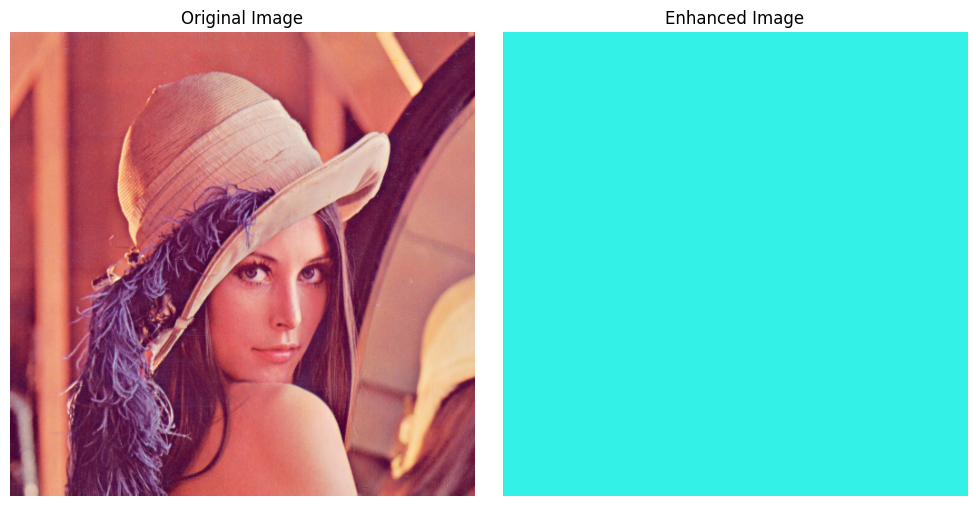

In [14]:
# Convert back to RGB and display (Add transformation function above)
enhanced_rgb = cv2.cvtColor(np.clip(enhanced_xyz, 0, 1).astype(np.float32), cv2.COLOR_XYZ2RGB)
display_images(image_rgb, enhanced_rgb)